## 点云交互显示与圈选
- 汪星宇
- 2021年12月

Open3D 官方提供了简单的点云交互功能, 可以满足基本的点云圈选显示功能, 官方的教程, [Interactive visualization](http://www.open3d.org/docs/0.14.1/tutorial/visualization/interactive_visualization.html).

不过, 圈选需要调用`o3d.visualization.draw_geometries_with_editing`, 好处是不需要进行额外的操作.

目前仅能实现两个功能:
1. 点云二维圈选, 保存并显示圈选的二维投影范围内的内容
2. 手动选点的ICP配准, 选取两幅点云中位置相近的几个点, 然后进行ICP配准

In [7]:
# examples/python/visualization/interactive_visualization.py
import numpy as np
import copy
import open3d as o3d
import open3d_tutorial

# 使用指南, 一般先调好视角, 按键K锁定, ctrl+左键圈选, 按键C保存
def demo_crop_geometry():
    print("Demo for manual geometry cropping")
    print(
        "1) Press 'Y' twice to align geometry with negative direction of y-axis"
    )
    print("2) Press 'K' to lock screen and to switch to selection mode")
    print("3) Drag for rectangle selection,")
    print("   or use ctrl + left click for polygon selection")
    print("4) Press 'C' to get a selected geometry and to save it")
    print("5) Press 'F' to switch to freeview mode")
    pcd = o3d.io.read_point_cloud("../data/cloud_bin_0.pcd")
    o3d.visualization.draw_geometries_with_editing([pcd])

demo_crop_geometry()


Demo for manual geometry cropping
1) Press 'Y' twice to align geometry with negative direction of y-axis
2) Press 'K' to lock screen and to switch to selection mode
3) Drag for rectangle selection,
   or use ctrl + left click for polygon selection
4) Press 'C' to get a selected geometry and to save it
5) Press 'F' to switch to freeview mode


原始的点云数据显示如下:

![png](../docs/点云交互显示与圈选/1.png)

按住`ctrl+letf click`圈选二维形状如下:

![png](../docs/点云交互显示与圈选/2.png)

选中的二维形状投影包含的三维点云如下:

![png](../docs/点云交互显示与圈选/3.png)

我们可以记录选中的点云文件和圈选点的坐标(以`JSON`格式存放), 但是似乎还是有点bug, JSON中圈选的点坐标显示为`null`

![png](../docs/点云交互显示与圈选/4.png)

Demo for manual ICP
Visualization of two point clouds before manual alignment


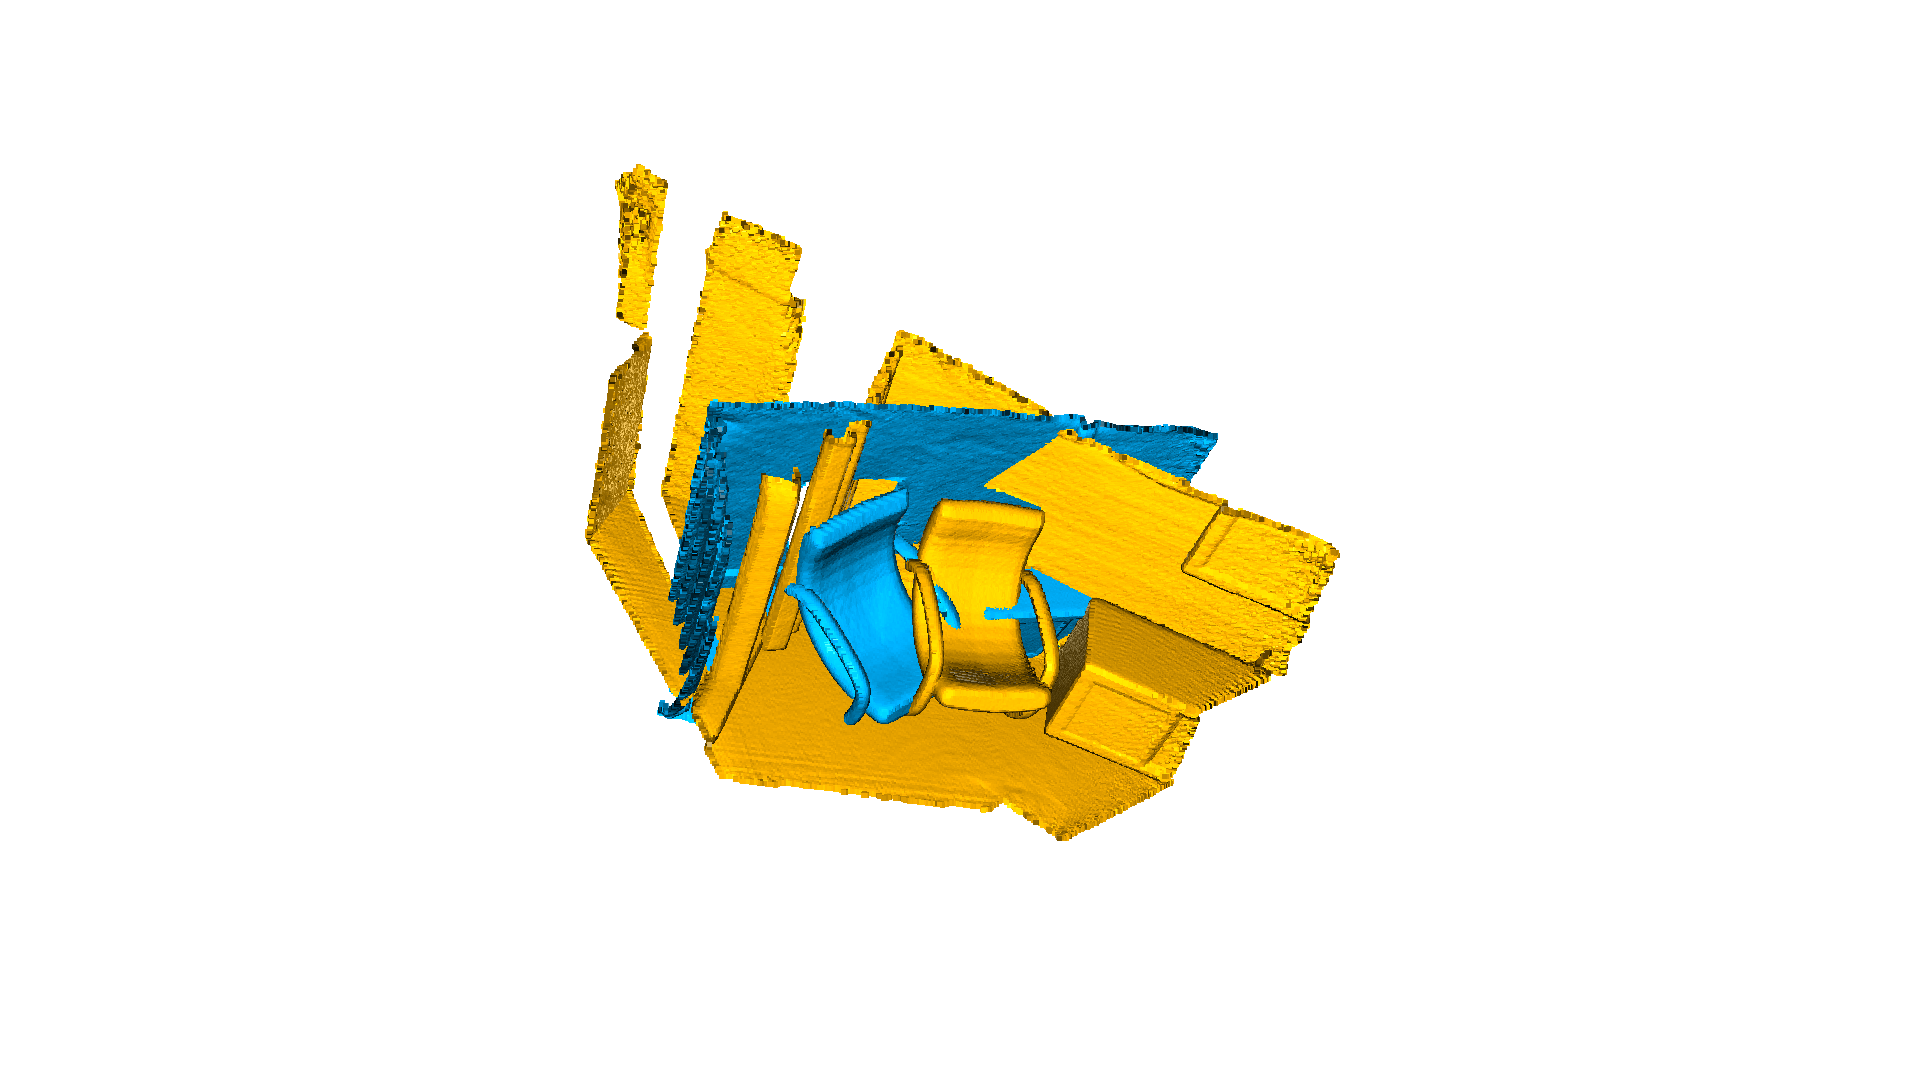


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #58200 (2.2, 1.6, 1.5) to add in queue.
[Open3D INFO] Picked point #55998 (2.6, 1.6, 1.6) to add in queue.
[Open3D INFO] Picked point #76531 (2.9, 1.9, 1.1) to add in queue.


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #35388 (1.6, 1.7, 1.3) to add in queue.
[Open3D INFO] Picked point #38521 (2.0, 1.6, 1.6) to add in queue.
[Open3D INFO] Picked point #69797 (2.4, 2.0, 1.5) to add in queue.
[Open3D INFO] Remove picked point #69797 from pick queue.
[Open3D INFO] Picked point #72049 (2.5, 2.0, 1.4) to add in queue.

Compute a rough transform using the correspondences given by user
Perform point-to-point ICP refinement


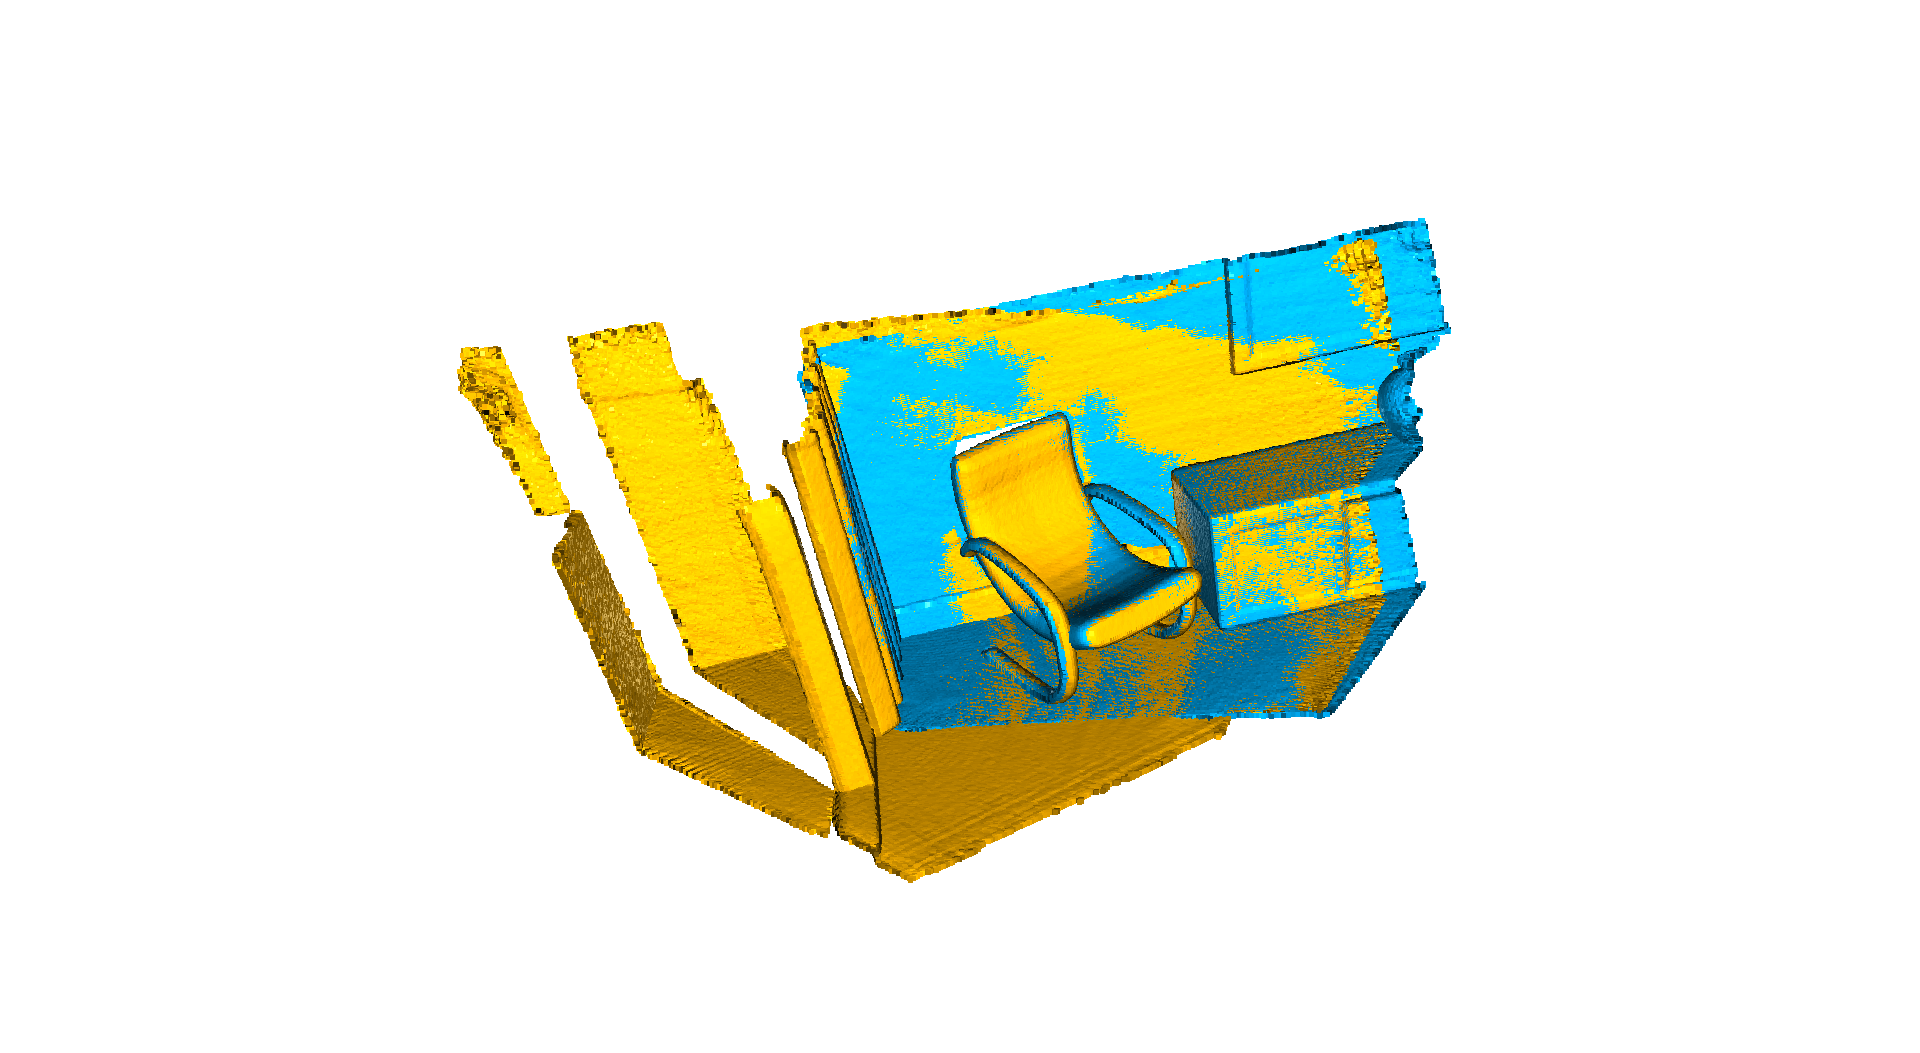

In [8]:
# 选点函数
def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

# 绘制配准结果
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

# 手动选点配准
def demo_manual_registration():
    print("Demo for manual ICP")
    source = o3d.io.read_point_cloud("../data/cloud_bin_0.pcd")
    target = o3d.io.read_point_cloud("../data/cloud_bin_1.pcd")
    print("Visualization of two point clouds before manual alignment")
    draw_registration_result(source, target, np.identity(4))

    # pick points from two point clouds and builds correspondences
    picked_id_source = pick_points(source)
    picked_id_target = pick_points(target)
    assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
    assert (len(picked_id_source) == len(picked_id_target))
    corr = np.zeros((len(picked_id_source), 2))
    corr[:, 0] = picked_id_source
    corr[:, 1] = picked_id_target

    # estimate rough transformation using correspondences
    print("Compute a rough transform using the correspondences given by user")
    p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
    trans_init = p2p.compute_transformation(source, target,
                                            o3d.utility.Vector2iVector(corr))

    # point-to-point ICP for refinement
    print("Perform point-to-point ICP refinement")
    threshold = 0.03  # 3cm distance threshold
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    draw_registration_result(source, target, reg_p2p.transformation)
    print("")

demo_manual_registration()

点云配准的原始数据和配准结果如上图所示, 具体的手动配准选点过程如下图所示

按住`shift+left click`选点, 按`shift+left click`顺次取消.
在一张点云中取相关点(3个及以上):

![png](../docs/点云交互显示与圈选/5.png)

在另一张点云的相近位置取关键点:

![png](../docs/点云交互显示与圈选/6.png)
